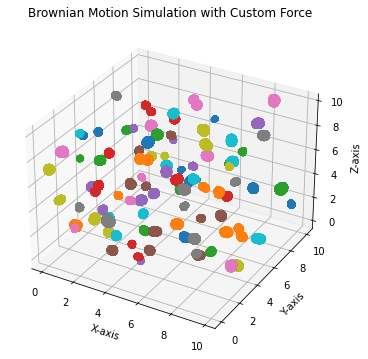

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simtk import openmm
from simtk.openmm import app, LangevinIntegrator, CustomExternalForce, Context

# Define parameters
num_particles = 100
box_size = 10.0
temperature = 300.0  # Temperature for Langevin dynamics
time_step = 0.001  # Time step for simulation

# Create a System and define particles with random positions and radii
system = openmm.System()
for _ in range(num_particles):
    system.addParticle(1.0)  # Mass of the particles

# Set up positions and radii for the particles
positions = np.random.rand(num_particles, 3) * box_size
radii = np.random.uniform(low=0.2, high=1.0, size=num_particles)

# Create a Langevin integrator for Brownian dynamics
integrator = LangevinIntegrator(temperature, 1.0 / time_step, time_step)

# Set up a custom force (e.g., simple harmonic potential)
custom_force = 'k * (r - r0)^2;'  # Custom force expression for a harmonic potential
custom_force += 'r = sqrt(x^2 + y^2 + z^2);'  # Calculate distance from the origin
custom_force += 'r0 = 2.0;'  # Equilibrium distance for the harmonic potential
custom_force += 'k = 10.0;'  # Spring constant for the harmonic potential

# Add the custom force to the system
system.addForce(CustomExternalForce(custom_force))

# Create a context and set particle positions
platform = openmm.Platform.getPlatformByName('CPU')  # Change to 'CUDA' if using GPU
context = Context(system, integrator, platform)
context.setPositions(positions)

# Run the simulation steps
num_steps = 1000
trajectory = []
groups = []

for _ in range(num_steps):
    state = context.getState(getPositions=True)
    positions = state.getPositions(asNumpy=True)
    trajectory.append(positions)
    
    # Check for particle contacts
    contact_pairs = []
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            distance = np.linalg.norm(positions[i] - positions[j])
            if distance < radii[i] + radii[j]:
                contact_pairs.append((i, j))  # Store the indices of contacting particles
    
    # Group particles that come into contact
    for pair in contact_pairs:
        group_found = False
        for group in groups:
            if pair[0] in group or pair[1] in group:
                group.update(pair)
                group_found = True
                break
        if not group_found:
            new_group = set(pair)
            groups.append(new_group)
    
    # Apply Brownian motion to particles within each group separately
    for group in groups:
        group_indices = list(group)
        group_system = openmm.System()
        
        for index in group_indices:
            group_system.addParticle(1.0)  # Mass of the particles
        
        # Apply the same custom force to the particles within the group
        group_force = CustomExternalForce(custom_force)
        group_system.addForce(group_force)
        
        # Create a new integrator for each group-specific context
        group_integrator = LangevinIntegrator(temperature, 1.0 / time_step, time_step)
        
        # Create a context and set particle positions for the group
        group_context = Context(group_system, group_integrator, platform)
        group_positions = positions[group_indices]
        group_context.setPositions(group_positions)
        
        # Run the simulation steps for the group
        group_trajectory = []
        for _ in range(10):  # Change the number of steps for each group if needed
            group_state = group_context.getState(getPositions=True)
            group_positions = group_state.getPositions(asNumpy=True)
            group_trajectory.append(group_positions)
            group_context.getIntegrator().step(1)
        
        group_trajectory = np.array(group_trajectory)
        
        """# Visualize the trajectory for the group using Matplotlib
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')
        
        # Plot particles with radii as scatter points
        for i in range(len(group_indices)):
            ax.scatter(group_trajectory[:, i, 0], group_trajectory[:, i, 1], group_trajectory[:, i, 2],
                       s=100*radii[group_indices[i]], alpha=0.6)
        
        plt.title('Brownian Motion Simulation for Contacted Particles Group')
        plt.show() """
    
    context.getIntegrator().step(1)

# Visualization of the overall trajectory (outside the loop)
trajectory = np.array(trajectory)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Plot particles with radii as scatter points
for i in range(num_particles):
    ax.scatter(trajectory[:, i, 0], trajectory[:, i, 1], trajectory[:, i, 2], s=100*radii[i], alpha=0.6)

plt.title('Brownian Motion Simulation with Custom Force')
plt.show()
